In [1]:
import pandas as pd
import glob

# Assuming all files are named like studentVle_0.csv to studentVle_7.csv
file_list = glob.glob("studentVle_*.csv")

# Combine all into one DataFrame
vle = pd.concat([pd.read_csv(file) for file in file_list], ignore_index=True)

# Save it (optional)
vle.to_csv("studentVle_combined.csv", index=False)


In [2]:
# Group by student and sum their VLE clicks
clicks = vle.groupby('id_student')['sum_click'].sum().reset_index()
clicks.columns = ['id_student', 'total_clicks']


In [4]:
# Load base data
info = pd.read_csv("studentInfo.csv")
reg = pd.read_csv("studentRegistration.csv")

# Create dropout label
reg['dropped_out'] = reg['date_unregistration'].notna().astype(int)

# Merge to create base df
df = info.merge(reg, on=['id_student', 'code_module', 'code_presentation'])

# THEN merge total_clicks
df = df.merge(clicks, on='id_student', how='left')
df['total_clicks'] = df['total_clicks'].fillna(0)


In [5]:
# Load assessment data
assess = pd.read_csv("studentAssessment.csv")

# Calculate average score per student
avg_score = assess.groupby('id_student')['score'].mean().reset_index()
avg_score.columns = ['id_student', 'avg_score']


In [6]:
df = df.merge(avg_score, on='id_student', how='left')
df['avg_score'] = df['avg_score'].fillna(0)


In [8]:
df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,dropped_out,total_clicks,avg_score
0,AAA,2013J,11391,M,East Anglian Region,1,90-100%,2,0,240,0,Pass,-159.0,NaN,0,934.0,82.0
1,AAA,2013J,28400,F,Scotland,1,20-30%,1,0,60,0,Pass,-53.0,NaN,0,1435.0,66.4
2,AAA,2013J,30268,F,North Western Region,0,30-40%,1,0,60,1,Withdrawn,-92.0,12.0,1,281.0,0.0
3,AAA,2013J,31604,F,South East Region,0,50-60%,1,0,60,0,Pass,-52.0,NaN,0,2158.0,76.0
4,AAA,2013J,32885,F,West Midlands Region,2,50-60%,0,0,60,0,Pass,-176.0,NaN,0,1034.0,54.4


Now we have dataset reading. Next we do encoding of categorical variable

In [7]:
from sklearn.preprocessing import LabelEncoder

for col in ['age_band', 'highest_education', 'disability']:
    df[col] = LabelEncoder().fit_transform(df[col])


Next we train the model

In [9]:
from sklearn.model_selection import train_test_split

X = df[['age_band', 'highest_education', 'disability',
        'num_of_prev_attempts', 'studied_credits',
        'total_clicks', 'avg_score']]
y = df['dropped_out']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))


[[3960  544]
 [ 922 1093]]
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      4504
           1       0.67      0.54      0.60      2015

    accuracy                           0.78      6519
   macro avg       0.74      0.71      0.72      6519
weighted avg       0.77      0.78      0.77      6519

ROC-AUC Score: 0.7864098744319908


Check if dataset is balanced? If <50 unbalanced.

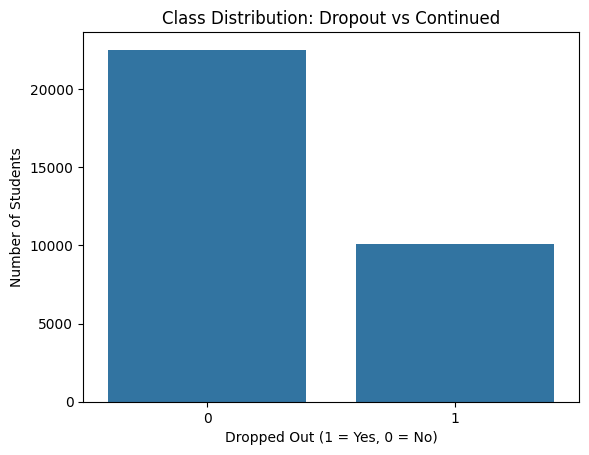

dropped_out
0    0.690977
1    0.309023
Name: proportion, dtype: float64


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check class balance
sns.countplot(x='dropped_out', data=df)
plt.title("Class Distribution: Dropout vs Continued")
plt.xlabel("Dropped Out (1 = Yes, 0 = No)")
plt.ylabel("Number of Students")
plt.show()

# Check proportion
print(df['dropped_out'].value_counts(normalize=True))


Feature Importance

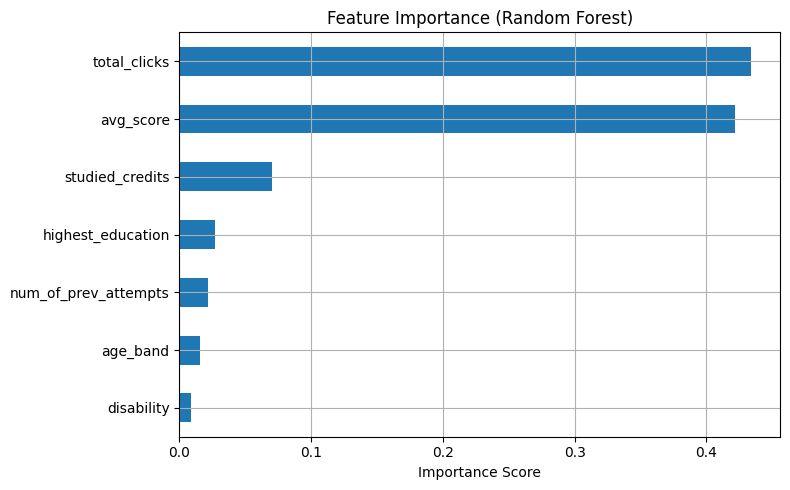

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Get and sort feature importances
importances = clf.feature_importances_
features = X.columns
feat_series = pd.Series(importances, index=features).sort_values()

# Plot
plt.figure(figsize=(8, 5))
feat_series.plot(kind='barh')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
!pip install xgboost

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Train model (adjust scale_pos_weight if needed)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1.5, random_state=42)
xgb.fit(X_train, y_train)

# Evaluate
y_pred_xgb = xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC Score:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:11:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.83      0.87      0.85      4504
           1       0.68      0.61      0.64      2015

    accuracy                           0.79      6519
   macro avg       0.76      0.74      0.75      6519
weighted avg       0.78      0.79      0.79      6519

ROC-AUC Score: 0.8167990184627726


Gradio App

In [18]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Manually fit encoders using known class values
le_age = LabelEncoder().fit(['0-35', '35-55', '55<='])
le_edu = LabelEncoder().fit([
    'Lower Than A Level',
    'A Level',
    'HE Qualification',
    'Post Graduate Qualification'
])
le_dis = LabelEncoder().fit(['N', 'Y'])

def predict_dropout(age_band, education, disability, prev_attempts, credits, clicks, score):
    # Convert input values to model-ready format
    input_data = pd.DataFrame([{
        'age_band': le_age.transform([age_band])[0],
        'highest_education': le_edu.transform([education])[0],
        'disability': le_dis.transform([disability])[0],
        'num_of_prev_attempts': prev_attempts,
        'studied_credits': credits,
        'total_clicks': clicks,
        'avg_score': score
    }])

    # Predict dropout probability
    prob = xgb.predict_proba(input_data)[0][1]
    label = "🔴 Likely to Drop Out" if prob > 0.5 else "🟢 Likely to Continue"
    return f"{label} (Dropout Probability: {round(prob, 2)})"

import gradio as gr

iface = gr.Interface(
    fn=predict_dropout,
    inputs=[
        gr.Dropdown(le_age.classes_.tolist(), label="Age Band"),
        gr.Dropdown(le_edu.classes_.tolist(), label="Highest Education"),
        gr.Dropdown(le_dis.classes_.tolist(), label="Disability (yes/no)"),
        gr.Slider(0, 10, step=1, label="Previous Attempts"),
        gr.Slider(0, 300, step=10, label="Studied Credits"),
        gr.Slider(0, 50000, step=100, label="Total Clicks (VLE)"),
        gr.Slider(0, 100, step=1, label="Average Assessment Score")
    ],
    outputs="text",
    title="🎓 Dropout Risk Predictor",
    description="Predict whether a student is at risk of dropping out using behavioral and academic data."
)

iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4286b3d4378155bfd6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
